In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import gc

import string

from tqdm import tqdm

import pickle

from sklearn.metrics import fbeta_score

import seaborn as sns

In [2]:
## store the embeddings and one hot encodings using np.save()

In [3]:
X_test,y_test,X_train,y_train = np.load('/kaggle/input/dal-train/embed_train.npy'),np.load('/kaggle/input/dal-train/labels_train.npy'),np.load('/kaggle/input/dal-train/embed_test.npy'),np.load('/kaggle/input/dal-train/labels_test.npy')

In [4]:
X_train = np.vstack((X_train,X_test))

y_train = np.vstack((y_train,y_test))

In [5]:
alphabets = list(string.ascii_uppercase)

In [6]:
# store both the multi label binarizer models

In [7]:
with open('/kaggle/input/dal-train/mlb.pkl','rb') as file:

    mlb = pickle.load(file)

with open('/kaggle/input/dal-train/mlb_letter.pkl','rb') as file:

    mlb_letter = pickle.load(file)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultiLabelBinarizer from version 1.5.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:
#y_train_letter

y_labels_train = mlb.inverse_transform(y_train)

y_labels_test = mlb.inverse_transform(y_test)

In [9]:
y_starter_train = [tuple(s[0] for s in tup) for tup in y_labels_train]

y_starter_test = [tuple(s[0] for s in tup) for tup in y_labels_test]

In [10]:
y_train_letter = mlb_letter.transform(y_starter_train)

y_test_letter = mlb_letter.transform(y_starter_test)

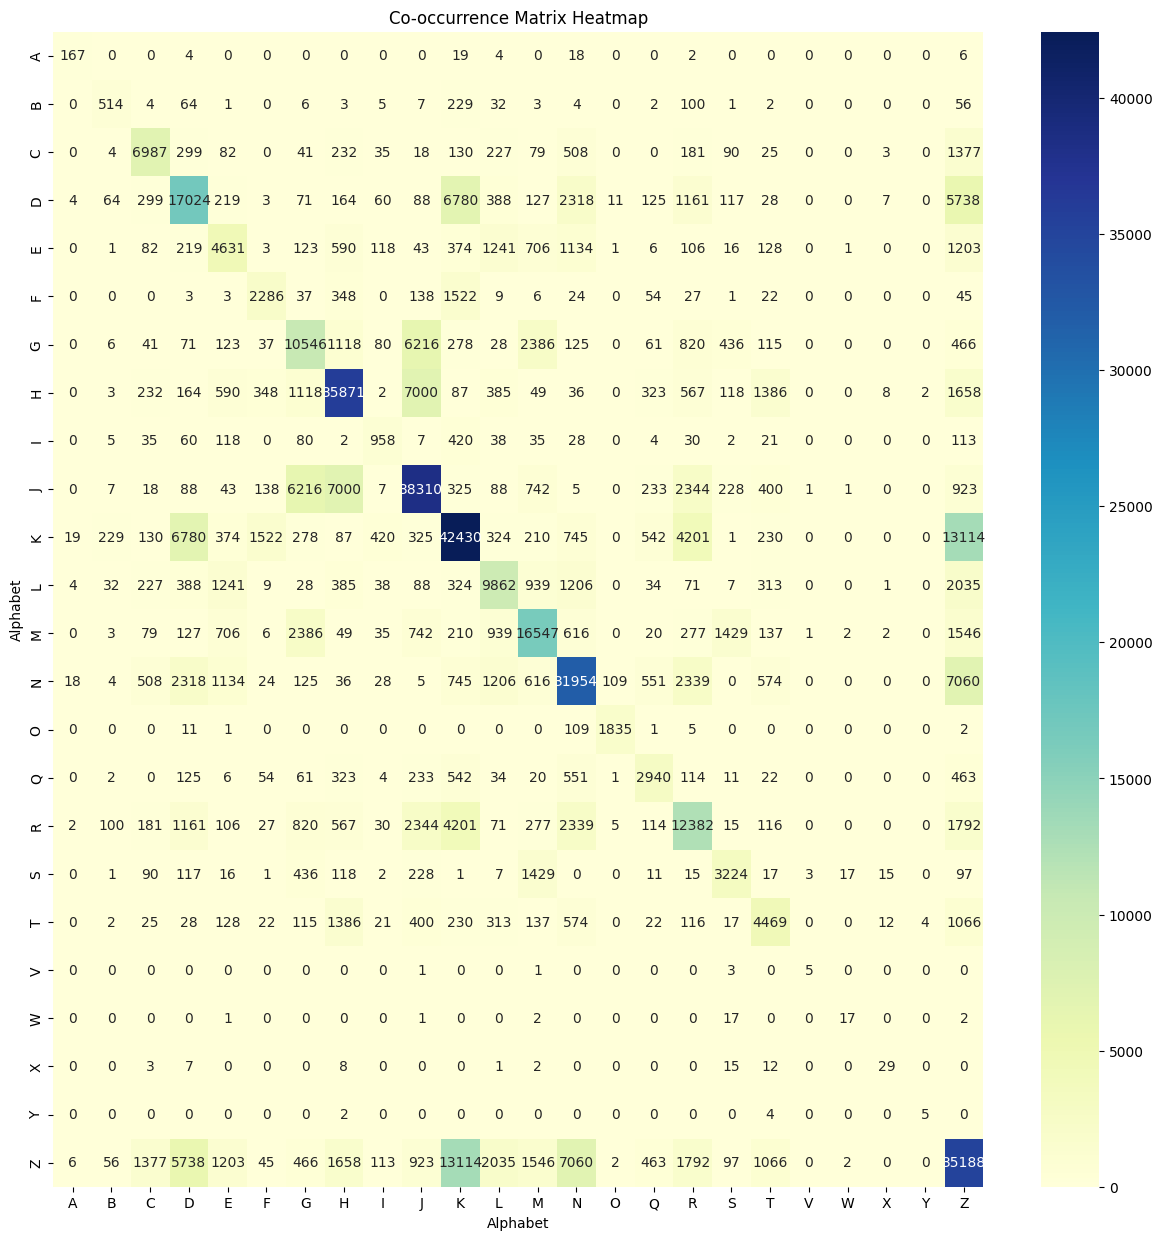

In [11]:
#co-occurence matrix
com = y_train_letter.T@y_train_letter
labels = [letter for letter in alphabets if letter!='P' and letter!='U']  # Replace with your actual labels

# Plotting the heatmap with custom labels
plt.figure(figsize=(15, 15))  # Adjust the figure size as needed
sns.heatmap(com, annot=True, fmt="d", cmap="YlGnBu", cbar=True,
            xticklabels=labels, yticklabels=labels)
plt.title("Co-occurrence Matrix Heatmap")
plt.xlabel("Alphabet")
plt.ylabel("Alphabet")
plt.show()


In [12]:
mlabels = mlb.classes_
for letter in tqdm(alphabets):
    # X should be embeddings, y should be multilabels
    indices  = [ind for ind,s in enumerate(mlabels) if s.startswith(letter)]
    if len(indices) == 1:
        print(letter)

100%|██████████| 26/26 [00:00<00:00, 3346.28it/s]

A
V
W
X
Y


In [13]:
from collections import defaultdict
coupler = defaultdict(list)
coupler.update({'K':['B','I'],'N':['A'],'S':['V','W','X'],'T':['Y']})
coupled = list(let for set in coupler.values() for let in set)

In [14]:
## couple labels 

In [15]:
gc.collect()

44512

In [16]:
import tensorflow as tf
from tensorflow.keras import backend as K

def micro_f2(y_true, y_pred):
    y_true = K.cast(y_true, tf.float32)
    y_pred = K.cast(y_pred > 0.5, tf.float32)  # Threshold to get binary predictions
    true_positives = K.sum(y_true * y_pred)
    possible_positives = K.sum(y_true)
    predicted_positives = K.sum(y_pred)
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f2 = (1 + 2**2) * (precision * recall) / (2**2 * precision + recall + K.epsilon())
    return f2




In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam


def build_model(input_length, num_labels):
    model = models.Sequential()

    # Word Embedding Layer dim 128

    # Bidirectional GRU Layer
    model.add(layers.Bidirectional(layers.GRU(256, return_sequences=True)))

    # Fully Connected Layer 1
    model.add(layers.Flatten())  # Flattening the output from the GRU layer
    model.add(layers.Dense(700, activation='relu'))
    model.add(layers.Dropout(0.2))

    # Fully Connected Layer 2 (Output Layer)
    model.add(layers.Dense(num_labels, activation='sigmoid'))  # Sigmoid for multi-label classification

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[micro_f2])

    return model





In [18]:
# first stage for letters
model1 = build_model(X_train.shape[1],y_train_letter.shape[1])
model1.fit(X_train.reshape(X_train.shape[0],1,X_train.shape[1]),y_train_letter, epochs = 20, batch_size = 64)

Epoch 1/20
3060/3060 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0424 - micro_f2: 0.8539
Epoch 2/20
3060/3060 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.0217 - micro_f2: 0.9242
Epoch 3/20
3060/3060 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.0189 - micro_f2: 0.9329
Epoch 4/20
3060/3060 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.0167 - micro_f2: 0.9408
Epoch 5/20
3060/3060 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.0149 - micro_f2: 0.9469
Epoch 6/20
3060/3060 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.0136 - micro_f2: 0.9518
Epoch 7/20
3060/3060 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.0123 - micro_f2: 0.9563
Epoch 8/20
3060/3060 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.0113 - micro_f2: 0.9605
Epoch 9/20
3060/3060 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.0105 - micro_f2: 0.9634
Epoch 10/20
3060/3060 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.0097 - micro_f2: 0.9664
Epoch 11/20
3060/3060 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.0091 - micro_f2: 0.9683
Epoch 12/20
3060/30

In [19]:
def filter_data_points(embeddings,labels, labels_to_check):
    #choose rows who have atleast one entry in 'labels_to_check' and choose labels data only from 'labels_to_check' columns
    interested_rows = np.any(labels[:, labels_to_check], axis=1)
    interested_labels = labels[interested_rows]
    filtered_labels = np.zeros((np.sum(interested_rows),labels.shape[1]))
    filtered_labels[:,labels_to_check] += interested_labels[:,labels_to_check] 
    filtered_embeddings = embeddings[interested_rows]
    return filtered_embeddings, filtered_labels

In [20]:
#Training a model for each alphabet

models2 = {}
for letter in tqdm(alphabets):
    # X should be embeddings, y should be multilabels
    indices  = [ind for ind,s in enumerate(mlabels) if s.startswith(letter)]
    if len(indices) == 0 or letter in coupled:
        models2[letter] = []
        continue
    else:
        for sec_letter in coupler[letter]:
            sec_indices = [ind for ind,s in enumerate(mlabels) if s.startswith(sec_letter)]
            indices.extend(sec_indices)
        print(letter)
        print(coupler[letter])
        filtered_data,filtered_labels = filter_data_points(X_train,y_train,indices)
    
        filtered_valid_data,filtered_valid_labels = filter_data_points(X_test,y_test,indices)
        model = build_model(filtered_data.shape[1],len(indices))
        model.fit(filtered_data.reshape(filtered_data.shape[0],1,filtered_data.shape[1]),filtered_labels[:,indices],epochs = 20,
                  validation_data = (filtered_valid_data.reshape(filtered_valid_data.shape[0],1,filtered_valid_data.shape[1]),filtered_valid_labels[:,indices]))
        models2[letter] = model

  0%|          | 0/26 [00:00<?, ?it/s]

C
[]
Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0966 - micro_f2: 0.5328 - val_loss: 0.0139 - val_micro_f2: 0.8709
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0151 - micro_f2: 0.8649 - val_loss: 0.0111 - val_micro_f2: 0.9025
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0119 - micro_f2: 0.8943 - val_loss: 0.0097 - val_micro_f2: 0.9231
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0104 - micro_f2: 0.9104 - val_loss: 0.0080 - val_micro_f2: 0.9346
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0088 - micro_f2: 0.9247 - val_loss: 0.0071 - val_micro_f2: 0.9403
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0076 - micro_f2: 0.9362 - val_loss: 0.0067 - val_micro_f2: 0.9426
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0069 - micro_f2: 0.9397 - val_loss: 0.0057 - val_micro_f2: 0.9538
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0061 - micro_f2: 0.9480 - val_loss: 0

 12%|█▏        | 3/26 [00:31<03:57, 10.34s/it]

D
[]
Epoch 1/20
532/532 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0632 - micro_f2: 0.5455 - val_loss: 0.0131 - val_micro_f2: 0.8420
Epoch 2/20
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0139 - micro_f2: 0.8410 - val_loss: 0.0103 - val_micro_f2: 0.8548
Epoch 3/20
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0114 - micro_f2: 0.8656 - val_loss: 0.0086 - val_micro_f2: 0.8885
Epoch 4/20
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0096 - micro_f2: 0.8878 - val_loss: 0.0073 - val_micro_f2: 0.9105
Epoch 5/20
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0083 - micro_f2: 0.9053 - val_loss: 0.0063 - val_micro_f2: 0.9150
Epoch 6/20
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0069 - micro_f2: 0.9195 - val_loss: 0.0055 - val_micro_f2: 0.9267
Epoch 7/20
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0063 - micro_f2: 0.9304 - val_loss: 0.0045 - val_micro_f2: 0.9469
Epoch 8/20
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0051 - micro_f2: 0.9435 - val_loss: 0

 15%|█▌        | 4/26 [01:37<10:28, 28.58s/it]

E
[]
Epoch 1/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1077 - micro_f2: 0.6470 - val_loss: 0.0211 - val_micro_f2: 0.8967
Epoch 2/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0217 - micro_f2: 0.9025 - val_loss: 0.0149 - val_micro_f2: 0.9301
Epoch 3/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0175 - micro_f2: 0.9173 - val_loss: 0.0136 - val_micro_f2: 0.9555
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0131 - micro_f2: 0.9421 - val_loss: 0.0098 - val_micro_f2: 0.9565
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0111 - micro_f2: 0.9536 - val_loss: 0.0091 - val_micro_f2: 0.9588
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0107 - micro_f2: 0.9527 - val_loss: 0.0079 - val_micro_f2: 0.9732
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0090 - micro_f2: 0.9611 - val_loss: 0.0080 - val_micro_f2: 0.9693
Epoch 8/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0077 - micro_f2: 0.9681 - val_loss: 0

 19%|█▉        | 5/26 [02:00<09:18, 26.60s/it]

F
[]
Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1717 - micro_f2: 0.7592 - val_loss: 0.0986 - val_micro_f2: 0.8395
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0797 - micro_f2: 0.8716 - val_loss: 0.0804 - val_micro_f2: 0.8595
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0713 - micro_f2: 0.8702 - val_loss: 0.0965 - val_micro_f2: 0.8586
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0774 - micro_f2: 0.8785 - val_loss: 0.0874 - val_micro_f2: 0.8625
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0666 - micro_f2: 0.8887 - val_loss: 0.0798 - val_micro_f2: 0.8682
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0617 - micro_f2: 0.8895 - val_loss: 0.0754 - val_micro_f2: 0.8529
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0632 - micro_f2: 0.8929 - val_loss: 0.0837 - val_micro_f2: 0.8685
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0665 - micro_f2: 0.8861 - val_loss: 0.0744 - val_mic

 23%|██▎       | 6/26 [02:12<07:23, 22.18s/it]

G
[]
Epoch 1/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0691 - micro_f2: 0.7401 - val_loss: 0.0119 - val_micro_f2: 0.9217
Epoch 2/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0149 - micro_f2: 0.9157 - val_loss: 0.0104 - val_micro_f2: 0.9389
Epoch 3/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0125 - micro_f2: 0.9295 - val_loss: 0.0094 - val_micro_f2: 0.9303
Epoch 4/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0113 - micro_f2: 0.9304 - val_loss: 0.0079 - val_micro_f2: 0.9456
Epoch 5/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0098 - micro_f2: 0.9421 - val_loss: 0.0074 - val_micro_f2: 0.9550
Epoch 6/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0089 - micro_f2: 0.9494 - val_loss: 0.0077 - val_micro_f2: 0.9488
Epoch 7/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0094 - micro_f2: 0.9447 - val_loss: 0.0070 - val_micro_f2: 0.9562
Epoch 8/20
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0086 - micro_f2: 0.9460 - val_loss: 0

 27%|██▋       | 7/26 [02:57<09:12, 29.09s/it]

H
[]
Epoch 1/20
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0357 - micro_f2: 0.4536 - val_loss: 0.0077 - val_micro_f2: 0.7323
Epoch 2/20
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0085 - micro_f2: 0.7141 - val_loss: 0.0068 - val_micro_f2: 0.7522
Epoch 3/20
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0076 - micro_f2: 0.7439 - val_loss: 0.0063 - val_micro_f2: 0.7804
Epoch 4/20
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0070 - micro_f2: 0.7629 - val_loss: 0.0057 - val_micro_f2: 0.7969
Epoch 5/20
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0066 - micro_f2: 0.7746 - val_loss: 0.0053 - val_micro_f2: 0.8148
Epoch 6/20
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0060 - micro_f2: 0.7933 - val_loss: 0.0049 - val_micro_f2: 0.8296
Epoch 7/20
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0056 - micro_f2: 0.8062 - val_loss: 0.0044 - val_micro_f2: 0.8487
Epoch 8/20
1121/1121 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0052 - micro_f2: 0.8

 31%|███       | 8/26 [05:21<19:16, 64.23s/it]

J
[]
Epoch 1/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0576 - micro_f2: 0.7830 - val_loss: 0.0302 - val_micro_f2: 0.8667
Epoch 2/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0316 - micro_f2: 0.8643 - val_loss: 0.0279 - val_micro_f2: 0.8774
Epoch 3/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0295 - micro_f2: 0.8723 - val_loss: 0.0271 - val_micro_f2: 0.8753
Epoch 4/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0273 - micro_f2: 0.8822 - val_loss: 0.0252 - val_micro_f2: 0.8914
Epoch 5/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0265 - micro_f2: 0.8840 - val_loss: 0.0244 - val_micro_f2: 0.8992
Epoch 6/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0249 - micro_f2: 0.8911 - val_loss: 0.0223 - val_micro_f2: 0.9055
Epoch 7/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0241 - micro_f2: 0.8936 - val_loss: 0.0216 - val_micro_f2: 0.9011
Epoch 8/20
1198/1198 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0228 - micro_f2: 0.

 38%|███▊      | 10/26 [07:54<18:37, 69.86s/it]

K
['B', 'I']
Epoch 1/20
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0370 - micro_f2: 0.5798 - val_loss: 0.0089 - val_micro_f2: 0.8435
Epoch 2/20
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0096 - micro_f2: 0.8349 - val_loss: 0.0070 - val_micro_f2: 0.8866
Epoch 3/20
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0079 - micro_f2: 0.8654 - val_loss: 0.0058 - val_micro_f2: 0.9017
Epoch 4/20
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0068 - micro_f2: 0.8851 - val_loss: 0.0049 - val_micro_f2: 0.9167
Epoch 5/20
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0059 - micro_f2: 0.9012 - val_loss: 0.0043 - val_micro_f2: 0.9298
Epoch 6/20
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0050 - micro_f2: 0.9150 - val_loss: 0.0034 - val_micro_f2: 0.9483
Epoch 7/20
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0043 - micro_f2: 0.9274 - val_loss: 0.0032 - val_micro_f2: 0.9478
Epoch 8/20
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0039 - micro

 42%|████▏     | 11/26 [10:45<23:47, 95.16s/it]

L
[]
Epoch 1/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1024 - micro_f2: 0.4566 - val_loss: 0.0367 - val_micro_f2: 0.7156
Epoch 2/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0401 - micro_f2: 0.6840 - val_loss: 0.0320 - val_micro_f2: 0.7252
Epoch 3/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0351 - micro_f2: 0.7133 - val_loss: 0.0277 - val_micro_f2: 0.7547
Epoch 4/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0304 - micro_f2: 0.7510 - val_loss: 0.0245 - val_micro_f2: 0.7929
Epoch 5/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0273 - micro_f2: 0.7804 - val_loss: 0.0212 - val_micro_f2: 0.8265
Epoch 6/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0238 - micro_f2: 0.8086 - val_loss: 0.0191 - val_micro_f2: 0.8439
Epoch 7/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0201 - micro_f2: 0.8441 - val_loss: 0.0171 - val_micro_f2: 0.8632
Epoch 8/20
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0180 - micro_f2: 0.8572 - val_loss: 0

 46%|████▌     | 12/26 [11:27<18:57, 81.22s/it]

M
[]
Epoch 1/20
518/518 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0532 - micro_f2: 0.4071 - val_loss: 0.0056 - val_micro_f2: 0.8008
Epoch 2/20
518/518 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0058 - micro_f2: 0.7838 - val_loss: 0.0039 - val_micro_f2: 0.8580
Epoch 3/20
518/518 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0043 - micro_f2: 0.8369 - val_loss: 0.0032 - val_micro_f2: 0.8789
Epoch 4/20
518/518 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0036 - micro_f2: 0.8624 - val_loss: 0.0028 - val_micro_f2: 0.8996
Epoch 5/20
518/518 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0029 - micro_f2: 0.8908 - val_loss: 0.0022 - val_micro_f2: 0.9237
Epoch 6/20
518/518 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0024 - micro_f2: 0.9126 - val_loss: 0.0019 - val_micro_f2: 0.9334
Epoch 7/20
518/518 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0021 - micro_f2: 0.9256 - val_loss: 0.0016 - val_micro_f2: 0.9448
Epoch 8/20
518/518 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0017 - micro_f2: 0.9390 - val_loss: 0

 50%|█████     | 13/26 [12:37<16:57, 78.28s/it]

N
['A']
Epoch 1/20
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0436 - micro_f2: 0.5804 - val_loss: 0.0116 - val_micro_f2: 0.8257
Epoch 2/20
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0118 - micro_f2: 0.8152 - val_loss: 0.0099 - val_micro_f2: 0.8404
Epoch 3/20
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0103 - micro_f2: 0.8365 - val_loss: 0.0089 - val_micro_f2: 0.8545
Epoch 4/20
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0091 - micro_f2: 0.8567 - val_loss: 0.0080 - val_micro_f2: 0.8662
Epoch 5/20
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0080 - micro_f2: 0.8731 - val_loss: 0.0066 - val_micro_f2: 0.8955
Epoch 6/20
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0074 - micro_f2: 0.8846 - val_loss: 0.0058 - val_micro_f2: 0.9040
Epoch 7/20
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0066 - micro_f2: 0.8959 - val_loss: 0.0054 - val_micro_f2: 0.9163
Epoch 8/20
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0059 - micro_f2: 0

 54%|█████▍    | 14/26 [14:50<18:41, 93.43s/it]

O
[]
Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1563 - micro_f2: 0.8936 - val_loss: 0.0663 - val_micro_f2: 0.9797
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0598 - micro_f2: 0.9820 - val_loss: 0.0615 - val_micro_f2: 0.9828
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0513 - micro_f2: 0.9837 - val_loss: 0.0635 - val_micro_f2: 0.9849
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0559 - micro_f2: 0.9777 - val_loss: 0.0591 - val_micro_f2: 0.9844
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0463 - micro_f2: 0.9812 - val_loss: 0.0591 - val_micro_f2: 0.9813
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0519 - micro_f2: 0.9791 - val_loss: 0.0556 - val_micro_f2: 0.9849
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0531 - micro_f2: 0.9814 - val_loss: 0.0498 - val_micro_f2: 0.9896
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0508 - micro_f2: 0.9825 - val_loss: 0.0571 - val_mic

 58%|█████▊    | 15/26 [15:00<12:46, 69.72s/it]

Q
[]
Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1407 - micro_f2: 0.5970 - val_loss: 0.0103 - val_micro_f2: 0.9575
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0126 - micro_f2: 0.9322 - val_loss: 0.0071 - val_micro_f2: 0.9685
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0090 - micro_f2: 0.9544 - val_loss: 0.0044 - val_micro_f2: 0.9715
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0051 - micro_f2: 0.9756 - val_loss: 0.0043 - val_micro_f2: 0.9801
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0049 - micro_f2: 0.9764 - val_loss: 0.0036 - val_micro_f2: 0.9866
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0049 - micro_f2: 0.9753 - val_loss: 0.0029 - val_micro_f2: 0.9851
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0033 - micro_f2: 0.9820 - val_loss: 0.0028 - val_micro_f2: 0.9843
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0037 - micro_f2: 0.9814 - val_loss: 0.0024 - val_mic

 65%|██████▌   | 17/26 [15:16<06:16, 41.83s/it]

R
[]
Epoch 1/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0788 - micro_f2: 0.5147 - val_loss: 0.0112 - val_micro_f2: 0.8874
Epoch 2/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0124 - micro_f2: 0.8741 - val_loss: 0.0077 - val_micro_f2: 0.9228
Epoch 3/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0089 - micro_f2: 0.9081 - val_loss: 0.0068 - val_micro_f2: 0.9329
Epoch 4/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0070 - micro_f2: 0.9297 - val_loss: 0.0046 - val_micro_f2: 0.9537
Epoch 5/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0058 - micro_f2: 0.9404 - val_loss: 0.0040 - val_micro_f2: 0.9642
Epoch 6/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0046 - micro_f2: 0.9561 - val_loss: 0.0035 - val_micro_f2: 0.9687
Epoch 7/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0040 - micro_f2: 0.9611 - val_loss: 0.0033 - val_micro_f2: 0.9695
Epoch 8/20
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0035 - micro_f2: 0.9670 - val_loss: 0

 69%|██████▉   | 18/26 [16:10<05:59, 44.95s/it]

S
['V', 'W', 'X']
Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1512 - micro_f2: 0.2771 - val_loss: 0.0152 - val_micro_f2: 0.6979
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0146 - micro_f2: 0.7545 - val_loss: 0.0092 - val_micro_f2: 0.8549
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0094 - micro_f2: 0.8542 - val_loss: 0.0068 - val_micro_f2: 0.8937
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0077 - micro_f2: 0.8870 - val_loss: 0.0056 - val_micro_f2: 0.9253
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0066 - micro_f2: 0.9028 - val_loss: 0.0045 - val_micro_f2: 0.9459
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0051 - micro_f2: 0.9298 - val_loss: 0.0041 - val_micro_f2: 0.9326
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0046 - micro_f2: 0.9372 - val_loss: 0.0030 - val_micro_f2: 0.9536
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0036 - micro_f2: 0.9536 

 73%|███████▎  | 19/26 [16:28<04:25, 37.92s/it]

T
['Y']
Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1424 - micro_f2: 0.4588 - val_loss: 0.0417 - val_micro_f2: 0.7638
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0414 - micro_f2: 0.7530 - val_loss: 0.0318 - val_micro_f2: 0.8399
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0350 - micro_f2: 0.7846 - val_loss: 0.0274 - val_micro_f2: 0.8393
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0301 - micro_f2: 0.8261 - val_loss: 0.0246 - val_micro_f2: 0.8507
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0266 - micro_f2: 0.8474 - val_loss: 0.0199 - val_micro_f2: 0.8926
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0229 - micro_f2: 0.8718 - val_loss: 0.0158 - val_micro_f2: 0.9073
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0193 - micro_f2: 0.8931 - val_loss: 0.0154 - val_micro_f2: 0.9243
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0174 - micro_f2: 0.9045 - val_loss

 77%|███████▋  | 20/26 [16:49<03:20, 33.37s/it]

Z
[]
Epoch 1/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0356 - micro_f2: 0.7316 - val_loss: 0.0079 - val_micro_f2: 0.8865
Epoch 2/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0084 - micro_f2: 0.8863 - val_loss: 0.0064 - val_micro_f2: 0.9027
Epoch 3/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0066 - micro_f2: 0.9078 - val_loss: 0.0052 - val_micro_f2: 0.9267
Epoch 4/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0055 - micro_f2: 0.9242 - val_loss: 0.0043 - val_micro_f2: 0.9414
Epoch 5/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0046 - micro_f2: 0.9376 - val_loss: 0.0034 - val_micro_f2: 0.9549
Epoch 6/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0039 - micro_f2: 0.9481 - val_loss: 0.0032 - val_micro_f2: 0.9567
Epoch 7/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0034 - micro_f2: 0.9546 - val_loss: 0.0025 - val_micro_f2: 0.9683
Epoch 8/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0029 - micro_f2: 0.96

100%|██████████| 26/26 [19:08<00:00, 44.19s/it]


In [21]:
def final_pred(X_test,pred_1,mlabels,models):
    pred_2 = np.zeros((X_test.shape[0],len(mlabels)))
    ind = 0
    coupled = list(let for set in coupler.values() for let in set)
    for letter in tqdm(alphabets):
        indices  = [ind for ind,s in enumerate(mlabels) if s.startswith(letter)]

        if letter == 'P' or letter == 'U':
            continue
        reqd_data = np.any(pred_1[:,ind].reshape(-1,1),axis = 1)  #all rows where the pred_1 is 1 for the given letter
        reqd_model = models[letter]
        X_reqd = X_test[reqd_data,:]
        ind +=1
        if np.sum(reqd_data) == 0:
            continue
        elif letter in coupled:
            continue
        else:
            for sec_letter in coupler[letter]:
                sec_indices = [ind for ind,s in enumerate(mlabels) if s.startswith(sec_letter)]
                indices.extend(sec_indices)

            pred_2[np.ix_(reqd_data,indices)] += reqd_model.predict(X_reqd)>0.5               
                
    return pred_2

In [22]:
gc.collect()

2254

In [23]:
real_test = np.load('/kaggle/input/dal-train/test_data.npy')

In [24]:
pred_1 = model1.predict(real_test.reshape(real_test.shape[0],1,real_test.shape[1]))>0.5

3110/3110 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


In [25]:
pred_2 = mlb.inverse_transform(final_pred(real_test.reshape(real_test.shape[0],1,real_test.shape[1]),pred_1,mlabels,models2))

  0%|          | 0/26 [00:00<?, ?it/s]

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 12%|█▏        | 3/26 [00:00<00:02,  8.10it/s]

508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 15%|█▌        | 4/26 [00:02<00:13,  1.59it/s]

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


 19%|█▉        | 5/26 [00:02<00:11,  1.81it/s]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 23%|██▎       | 6/26 [00:02<00:09,  2.06it/s]

214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 27%|██▋       | 7/26 [00:03<00:11,  1.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 31%|███       | 8/26 [00:04<00:09,  1.88it/s]

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|███▊      | 10/26 [00:04<00:05,  2.72it/s]

1353/1353 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


 42%|████▏     | 11/26 [00:08<00:20,  1.35s/it]

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


 46%|████▌     | 12/26 [00:09<00:15,  1.10s/it]

975/975 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


 50%|█████     | 13/26 [00:12<00:21,  1.67s/it]

171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 54%|█████▍    | 14/26 [00:13<00:17,  1.43s/it]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


 65%|██████▌   | 17/26 [00:13<00:06,  1.38it/s]

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


 69%|██████▉   | 18/26 [00:14<00:05,  1.47it/s]

481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 73%|███████▎  | 19/26 [00:15<00:06,  1.10it/s]

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 77%|███████▋  | 20/26 [00:16<00:04,  1.26it/s]

956/956 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


100%|██████████| 26/26 [00:18<00:00,  1.38it/s]


In [26]:
empty_pred = [i for i,pred in enumerate(pred_2) if pred == ()]

In [27]:
len(empty_pred)

3259

In [28]:
import csv

filename = "output_29.csv"



# Write the list of tuples to the CSV file

with open(filename, mode='w', newline='') as file:

    writer = csv.writer(file)

    # Write the header

    writer.writerow(["id", "labels"])

    

    # Write each row with sequential ID

    for idx, labels in enumerate(pred_2, start=1):

        # Join labels with ';' and write to file

        writer.writerow([idx, ";".join(labels)])



print(f"Data saved to {filename}")

Data saved to output_29.csv


In [29]:
final_pred

<function __main__.final_pred(X_test, pred_1, mlabels, models)>

In [30]:
gc.collect()

3474

In [31]:
# pred_2 = final_pred(X_test[:n_test],y_cluster_no,means,mlabels,models_dict)

In [32]:
# print(f"Score is {fbeta_score(pred_2,y_test[:n_test],beta = 2,average = 'micro')}")

In [33]:
### A few comparisons ###

In [34]:
mlb.inverse_transform(pred_2[:5])

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
y_labels_test[:5]

In [ ]:
# means[np.where((means>=0.1) * (means<=1.00))[0],np.where((means>=0.1) * (means<=1.00))[1]] = 1

# means[np.where(means!=1)] = 0